# <center>Metody Numeryczne</center>

# Laboratorium 9: Interpolacja


**Wykonał:** \<imię i nazwisko\>

<br>

### **Metoda zaliczenia:**

Podczas zajęć należy wykonać poniższe polecenia oraz udzielić odpowiedzi na pytania zamieszczone w treści zadań. 

Wszystkie funkcje wymagane w ramach ćwiczenia należy zaimplementować w pliku `main.py`. Poprawność ich działania należy zweryfikować za pomocą testów jednostkowych dostępnych w pliku `test_main.py`.

### **Cel zajęć:**

Celem laboratorium jest praktyczne zapoznanie z zagadnieniem interpolacji wielomianowej, ze szczególnym uwzględnieniem jej wariantów numerycznie stabilnych. W ramach zajęć przeanalizowane zostanie działanie interpolacji barycentrycznej opartej na węzłach Czebyszewa.


### **Uwagi wstępne:**
- Funkcje wymagające implementacji (lub zaimplementowane na poprzednich laboratoriach) oznaczone są pochyłą czcionką maszynową (np. *`my_func()`*).

- W skrypcie stosuje się następujące skróty:

    - `np` - `numpy`,
    - `sp` - `scipy`.

---

In [7]:
# !python -m pip install numpy scipy matplotlib

import main

import numpy as np
import scipy as sp
import time
import matplotlib.pyplot as plt

---

### **Zadanie 1.**

W celu wykonywania interpolacji należy przygotować funkcję wyliczającą wektor [węzłów Czebyszewa](https://en.wikipedia.org/wiki/Chebyshev_nodes) drugiego rodzaju (funkcja *`chebyshev_nodes()`*) dany wzorem:
  
$$
x_k = \cos\left(\cfrac{k\pi}{n}\right),\ \ \ k = 0,1,2,...,n
$$

oraz wagi barycentryczne dla tego typu wezłów (funkcja *`bar_cheb_weights()`*):

$$
\begin{align*}
    w_j={}&(-1)^j\delta_j\\
    \delta_j={}&
    \begin{cases}
        \frac{1}{2}, \quad j=\{0, n\}\\
        1, \quad j\in(0,n)
    \end{cases}
\end{align*}
$$


In [3]:
def chebyshev_nodes(n: int = 10) -> np.ndarray | None:
    """Funkcja generująca wektor węzłów Czebyszewa drugiego rodzaju (n,) 
    i sortująca wynik od najmniejszego do największego węzła.

    Args:
        n (int): Liczba węzłów Czebyszewa.
    
    Returns:
        (np.ndarray): Wektor węzłów Czebyszewa (n,).
        Jeżeli dane wejściowe są niepoprawne funkcja zwraca `None`.
    """
    if not isinstance(n, int) or n < 2:
        return None

    k = np.arange(n, dtype=float)
    nodes = np.cos(np.pi * k / (n - 1))
    return nodes

def bar_cheb_weights(n: int = 10) -> np.ndarray | None:
    """Funkcja tworząca wektor wag dla węzłów Czebyszewa wymiaru (n,).

    Args:
        n (int): Liczba wag węzłów Czebyszewa.
    
    Returns:
        (np.ndarray): Wektor wag dla węzłów Czebyszewa (n,).
        Jeżeli dane wejściowe są niepoprawne funkcja zwraca `None`.
    """
    if not isinstance(n, int) or n < 2:
        return None

    weights = (-1.0) ** np.arange(n, dtype=float)
    weights[0] = 0.5
    weights[-1] = 0.5 * ((-1.0) ** (n - 1))
    return weights

---

### **Zadanie 2.**

Zaimplementuj podane funkcje, które będą używane w dalszej części laboratorium:

1. Ciągłą nieróżniczkowalną: $f_1(x) = \mathrm{sgn}(x)x+x^2$.

2. Różniczkowalną jednokrotnie: $f_2(x) = \mathrm{sgn}(x)x^{2}$.

3. Różniczkowalną trzykrotnie: $f_3(x)=|\sin(5 x)|^3$.

4. Trzy analityczne postaci: $f_{4a}(x) = \cfrac{1}{1+ax^2} \ $ dla $a \in \{1,25,100\}$. 

5. Nieciągłą: $f_5(x) = \mathrm{sgn}(x)$.

Funkcje można zaimplementować w notebooku lub w pliku `main.py`. 

>**Wskazówka:** Do definicji funkcji w notatniku można użyć [wyrażenia lambda](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions).
>
>$\mathrm{sgn}(x)$ to funkcja [signum](https://en.wikipedia.org/wiki/Sign_function).

In [4]:
# ===== Twoja implementacja tutaj =====
f1 = lambda x: np.sign(x) * x + x**2
f2 = lambda x: np.sign(x) * x**2
f3 = lambda x: np.abs(np.sin(5 * x))**3
def f_a(a):
    return lambda x: 1 / (1 + a * x**2)

f4_1   = f_a(1)
f4_25  = f_a(25)
f4_100 = f_a(100)
f5 = lambda x: np.sign(x)

---

### **Zadanie 3.**

Do oceny jakości interpolacji stosuje się normę wektorową $\ell_{\infty}$. Dla różnicy wektorów definiujemy ją jako:  
  
$$
\ell_{\infty} = ||\mathbf{x_1}-\mathbf{x_2}||_\infty = \sup\{|\mathbf{x_1}-\mathbf{x_2}|\}
$$  
  
Zaimplementuj funkcję *`L_inf()`* wyznaczającą normę $\ell_{\infty}$. 


In [5]:
def L_inf(
    xr: int | float | list | np.ndarray, x: int | float | list | np.ndarray
) -> float | None:
    """Funkcja obliczająca normę L-nieskończoność. Powinna działać zarówno na 
    wartościach skalarnych, listach, jak i wektorach biblioteki numpy.

    Args:
        xr (int | float | list | np.ndarray): Wartość dokładna w postaci 
            skalara, listy lub wektora (n,).
        x (int | float | list | np.ndarray): Wartość przybliżona w postaci 
            skalara, listy lub wektora (n,).

    Returns:
        (float): Wartość normy L-nieskończoność.
        Jeżeli dane wejściowe są niepoprawne funkcja zwraca `None`.
    """
    try:
        xr_arr = np.asarray(xr, dtype=float)
        x_arr = np.asarray(x, dtype=float)
    except (TypeError, ValueError):
        return None

    if xr_arr.shape != x_arr.shape:
        return None

    diff = np.abs(xr_arr - x_arr)
    return float(np.max(diff))

---

### **Zadanie 4.**

**Punkt 1.**

Zaimlementuj wzór barycentryczny podany na wykładzie jako funkcję *`barycentric_inte()`*.

<br>

**Punkt 2.**

Dla funkcji ciągłej nieróżniczkowalnej z **Zadania 2.** ($f_1(x)$) przeprowadź interpolację metodą [barycentryczną](https://people.maths.ox.ac.uk/trefethen/barycentric.pdf) zarówno przy użyciu funkcji [`sp.interpolate.barycentric_interpolate()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.barycentric_interpolate.html) jak i korzystając z zaimplementowanego wzoru barycentrycznego. 

W tym celu dla $n \in \{1, 2, 3, 4, 5\}$:

1. W węzłach Czebyszewa wykonaj interpolację rzędu $10^n$.

2. Wykreśl wykresy obrazujące wyniki interpolacji (wykres oryginalnej funkcji i funkcji interpolującej w $1000$ punktach).

3. Zbadaj jakość interpolacji za pomocą normy $\ell_{\infty}$.

Opisz jak zmieniały się wartość normy $\ell_{\infty}$ oraz czas obliczeń w zależności od rzędu interpolacji.


Wraz ze wzrostem rzędu interploacji wielkość normy maleje. Dla liniowego zachowania normy jewst wymagany wykładniczy wzrost rzędu interpolacji.

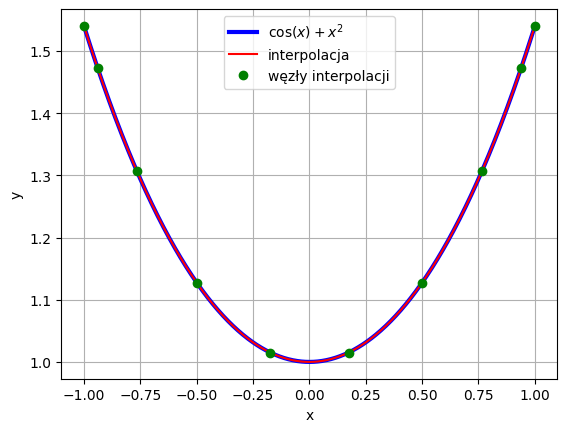

In [3]:
# Przykład użycia interpolacji barycentrycznej z wykorzystaniem węzłów Czebyszewa

# Funkcja do interpolacji
def f(x):
    return np.cos(x) + x**2

# Wektor współrzędnych, dla których chcemy wyliczyć wartości wielomianu interpolacyjnego
x = np.linspace(-1, 1, 1000)

# Węzły Czebyszewa
n = int(1e1)  # Liczba węzłów
xch = main.chebyshev_nodes(n)

# Interpoalcja
yimp = sp.interpolate.barycentric_interpolate(xch, f(xch), x)

plt.plot(x, f(x), 'b', linewidth=3, label=r'$\cos(x)+x^2$')
plt.plot(x, yimp, 'r', label='interpolacja')
plt.plot(xch, f(xch), 'go', label='węzły interpolacji')
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc=0)
plt.grid()
plt.show()


===== n = 1, rząd = 10, liczba węzłów = 11 =====
‖f - p_scipy‖liminf ≈ 5.922e-02,  czas SciPy  ≈ 0.001 s
‖f - p_own  ‖liminf ≈ 5.922e-02,  czas własny ≈ 0.093 s


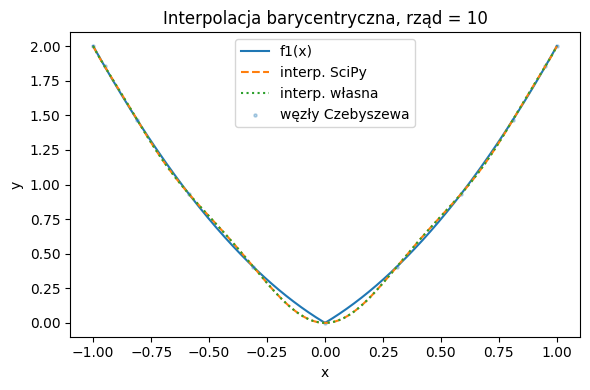


===== n = 2, rząd = 100, liczba węzłów = 101 =====
‖f - p_scipy‖liminf ≈ 5.965e-03,  czas SciPy  ≈ 0.004 s
‖f - p_own  ‖liminf ≈ 5.965e-03,  czas własny ≈ 0.093 s


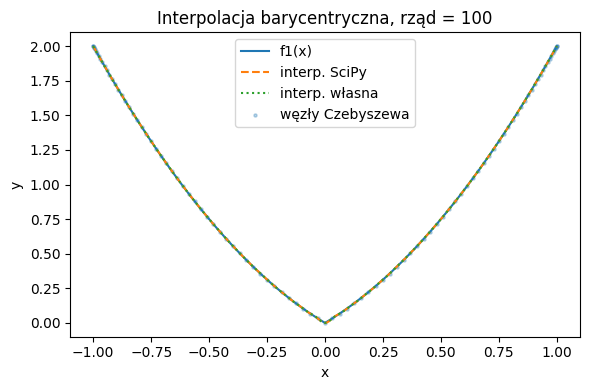


===== n = 3, rząd = 1000, liczba węzłów = 1001 =====
‖f - p_scipy‖liminf ≈ 5.740e-04,  czas SciPy  ≈ 0.042 s
‖f - p_own  ‖liminf ≈ 5.740e-04,  czas własny ≈ 0.105 s


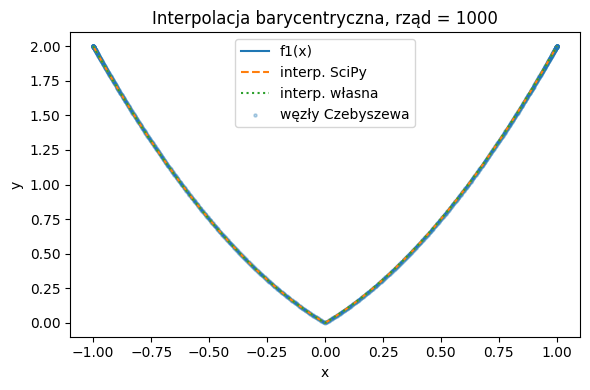


===== n = 4, rząd = 10000, liczba węzłów = 10001 =====
‖f - p_scipy‖liminf ≈ 8.304e-06,  czas SciPy  ≈ 0.845 s
‖f - p_own  ‖liminf ≈ 8.304e-06,  czas własny ≈ 0.184 s


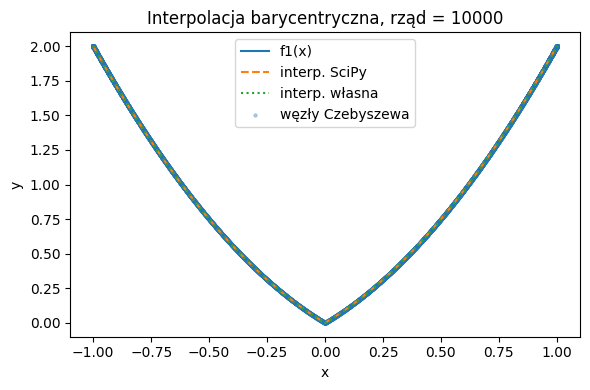


===== n = 5, rząd = 100000, liczba węzłów = 100001 =====
‖f - p_scipy‖liminf ≈ 6.551e-08,  czas SciPy  ≈ 68.786 s
‖f - p_own  ‖liminf ≈ 6.551e-08,  czas własny ≈ 1.119 s


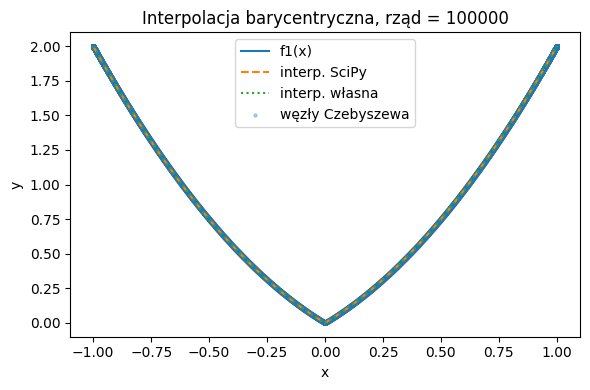


Podsumowanie: (rząd, err_scipy, t_scipy, err_own, t_own)
(10, 0.059219624368103255, 0.0008655001875013113, 0.05921962436810317, 0.09340179990977049)
(100, 0.005965418924417039, 0.0041102999821305275, 0.005965418924417008, 0.09317720006220043)
(1000, 0.0005739642836659303, 0.041894900146871805, 0.0005739642836658015, 0.10520759993232787)
(10000, 8.303505128587482e-06, 0.8448683000169694, 8.303505128184376e-06, 0.18442289996892214)
(100000, 6.550513148833453e-08, 68.78636070014909, 6.55051311717475e-08, 1.1191423998679966)


In [ ]:
# ===== Twoja implementacja tutaj =====
def barycentric_inte(
    xi: np.ndarray, yi: np.ndarray, wi: np.ndarray, x: np.ndarray
) -> np.ndarray | None:
    """Funkcja przeprowadza interpolację metodą barycentryczną dla zadanych 
    węzłów xi i wartości funkcji interpolowanej yi używając wag wi. Zwraca 
    wyliczone wartości funkcji interpolującej dla argumentów x w postaci 
    wektora (n,).

    Args:
        xi (np.ndarray): Wektor węzłów interpolacji (m,).
        yi (np.ndarray): Wektor wartości funkcji interpolowanej w węzłach (m,).
        wi (np.ndarray): Wektor wag interpolacji (m,).
        x (np.ndarray): Wektor argumentów dla funkcji interpolującej (n,).
    
    Returns:
        (np.ndarray): Wektor wartości funkcji interpolującej (n,).
        Jeżeli dane wejściowe są niepoprawne funkcja zwraca `None`.
    """
    try:
        xi = np.asarray(xi, dtype=float)
        yi = np.asarray(yi, dtype=float)
        wi = np.asarray(wi, dtype=float)
        x = np.asarray(x, dtype=float)
    except (TypeError, ValueError):
        return None

    if (
        xi.ndim != 1
        or yi.ndim != 1
        or wi.ndim != 1
        or x.ndim != 1
        or len(xi) != len(yi)
        or len(xi) != len(wi)
        or len(xi) < 2
    ):
        return None

    result = np.empty_like(x, dtype=float)

    for idx, xv in enumerate(x):
        diff = xv - xi
        zero_mask = np.isclose(diff, 0.0)

        if np.any(zero_mask):
            result[idx] = yi[zero_mask][0]
            continue

        tmp = wi / diff
        result[idx] = np.sum(tmp * yi) / np.sum(tmp)

    return result

ns = [1, 2, 3, 4, 5]
results = []

for n in ns:
    N = 10**n
    m = N + 1
    print(f"\n===== n = {n}, rząd = {N}, liczba węzłów = {m} =====")
    xi = chebyshev_nodes(m)
    wi = bar_cheb_weights(m)
    yi = f1(xi)
    x_plot = np.linspace(-1, 1, 1000)
    y_true = f1(x_plot)
    t0 = time.perf_counter()
    y_scipy = sp.interpolate.barycentric_interpolate(xi, yi, x_plot)
    t_scipy = time.perf_counter() - t0
    err_scipy = L_inf(y_true, y_scipy)
    t0 = time.perf_counter()
    y_own = barycentric_inte(xi, yi, wi, x_plot)
    t_own = time.perf_counter() - t0
    err_own = L_inf(y_true, y_own)
    results.append((N, err_scipy, t_scipy, err_own, t_own))
    print(f"‖f - p_scipy‖liminf ≈ {err_scipy:.3e},  czas SciPy  ≈ {t_scipy:.3f} s")
    print(f"‖f - p_own  ‖liminf ≈ {err_own:.3e},  czas własny ≈ {t_own:.3f} s")
    plt.figure(figsize=(6, 4))
    plt.plot(x_plot, y_true, label="f1(x)")
    plt.plot(x_plot, y_scipy, "--", label="interp. SciPy")
    plt.plot(x_plot, y_own, ":", label="interp. własna")
    plt.scatter(xi, yi, s=5, alpha=0.3, label="węzły Czebyszewa")
    plt.title(f"Interpolacja barycentryczna, rząd = {N}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\nPodsumowanie: (rząd, err_scipy, t_scipy, err_own, t_own)")
for row in results:
    print(row)


---

### **Zadanie 5.**

Dla funkcji jednokrotnie ($f_2(x)$) i trzykrotnie ($f_3(x)$) różniczkowalnych z **Zadania 2.** należy przeanalizować w pętli jakość interpolacji dla interpolacji rzędu $10^n$, gdzie $n \in \{1, 2, 3, 4, 5\}$. 

W tym celu:

1. Wylicz wartość funkcji i wielomianu interpolacyjnego w $1000$ punktów (nie będącymi węzłami interpolacji np. punkty równoodległe).

2. Wylicz normę różnicy tych wektorów (normę błędu) dla każdego badanego rzędu. Maksymalny rząd należy przyjąć gdy błąd będzie na poziomie zera maszynowego.

3. Dla każdej z funkcji sporządź wykres w skali podwójnie logarytmicznej (obie osie), w którym oś argumentów to rząd interpolacji a oś wartości to odpowiadająca mu norma błędu.

4. Dla porównania umieść na wykresie dodatkowo wykres $n^{-v}$, gdzie $v$ to rząd najwyższej pochodnej funkcji (zobacz wykład).


n=1, rząd interpolacji = 10
błąd L_inf = 7.616e-03

n=2, rząd interpolacji = 100
błąd L_inf = 7.532e-05

n=3, rząd interpolacji = 1000
błąd L_inf = 7.481e-07

n=4, rząd interpolacji = 10000
błąd L_inf = 3.652e-10

n=5, rząd interpolacji = 100000
błąd L_inf = 1.579e-08


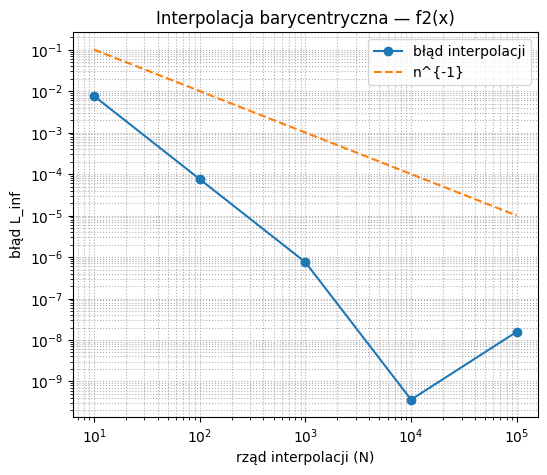


n=1, rząd interpolacji = 10
błąd L_inf = 2.771e-01

n=2, rząd interpolacji = 100
błąd L_inf = 1.426e-04

n=3, rząd interpolacji = 1000
błąd L_inf = 1.187e-07

n=4, rząd interpolacji = 10000
błąd L_inf = 4.569e-11

n=5, rząd interpolacji = 100000
błąd L_inf = 3.089e-08


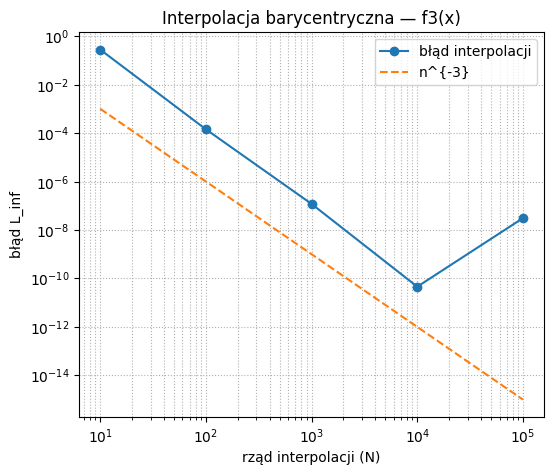

In [13]:
# ===== Twoja implementacja tutaj =====
errors_f2 = []
orders_f2 = []
x_test = np.linspace(-1, 1, 1000)
y_true_f2 = f2(x_test)
for n in [1, 2, 3, 4, 5]:
    N = 10**n
    m = N + 1
    print(f"\nn={n}, rząd interpolacji = {N}")
    xi = chebyshev_nodes(m)
    wi = bar_cheb_weights(m)
    yi = f2(xi)
    y_interp = barycentric_inte(xi, yi, wi, x_test)
    err = L_inf(y_true_f2, y_interp)
    print(f"błąd L_inf = {err:.3e}")
    orders_f2.append(N)
    errors_f2.append(err)
    if err < 1e-14:
        break

plt.figure(figsize=(6,5))
plt.loglog(orders_f2, errors_f2, "o-", label="błąd interpolacji")
orders_f2_arr = np.array(orders_f2, dtype=float)
plt.loglog(orders_f2_arr, orders_f2_arr**(-1), "--", label="n^{-1}")
plt.xlabel("rząd interpolacji (N)")
plt.ylabel("błąd L_inf")
plt.title("Interpolacja barycentryczna — f2(x)")
plt.grid(True, which="both", ls=":")
plt.legend()
plt.show()


errors_f3 = []
orders_f3 = []
x_test = np.linspace(-1, 1, 1000)
y_true_f3 = f3(x_test)
for n in [1, 2, 3, 4, 5]:
    N = 10**n
    m = N + 1
    print(f"\nn={n}, rząd interpolacji = {N}")
    xi = chebyshev_nodes(m)
    wi = bar_cheb_weights(m)
    yi = f3(xi)
    y_interp = barycentric_inte(xi, yi, wi, x_test)
    err = L_inf(y_true_f3, y_interp)
    print(f"błąd L_inf = {err:.3e}")
    orders_f3.append(N)
    errors_f3.append(err)
    if err < 1e-14:
        break

plt.figure(figsize=(6,5))
plt.loglog(orders_f3, errors_f3, "o-", label="błąd interpolacji")
orders_f3_arr = np.array(orders_f3, dtype=float)
plt.loglog(orders_f3_arr, orders_f3_arr**(-3), "--", label="n^{-3}")
plt.xlabel("rząd interpolacji (N)")
plt.ylabel("błąd L_inf")
plt.title("Interpolacja barycentryczna — f3(x)")
plt.grid(True, which="both", ls=":")
plt.legend()
plt.show()

---

### **Zadanie 6.**

Dla funkcji nieciągłej z **Zadania 2.** ($f_5(x)$) przeanalizować należy [efekt Gibbsa](https://en.wikipedia.org/wiki/Gibbs_phenomenon).

1. Oddzielnie dla parzystych i nieparzystych $n$ wylicz jaki jest minimalny błąd niezależny od rzędu. 

2. Odpowiedz dlaczego wartości dla parzystych i nieparzystych $n$ się różnią.

> **Wskazówka:** Wykonaj wykres funkcji i jej funkcji interpolującej.

Dla nieparzystych funkcja musi przejść przez skok w zerze co wymusza wcześniejszą zmianę wartości.

Minimalny błąd (n parzyste):   9.56199e-01 dla n = 60
Minimalny błąd (n nieparzyste): 1.97384e+00 dla n = 59


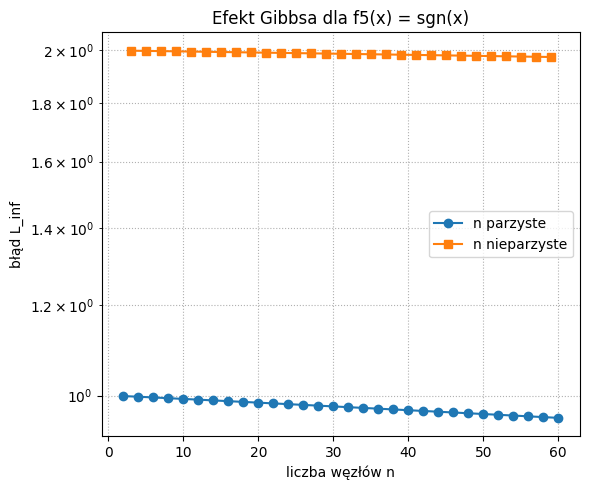

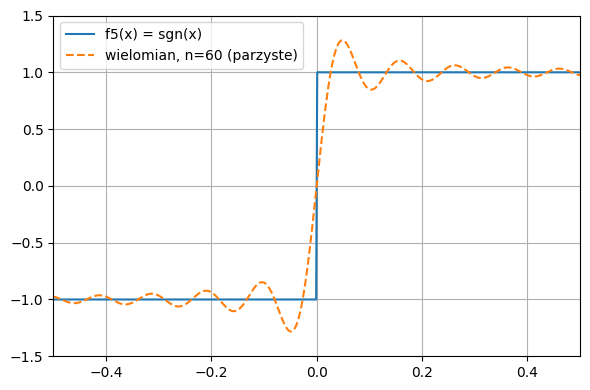

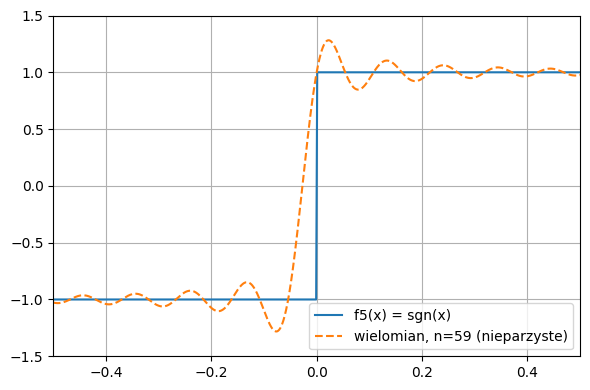

In [17]:
# ===== Twoja implementacja tutaj =====
x_test = np.linspace(-1, 1, 2001)
y_true = f5(x_test)
n_max = 60
ns_even = []
errs_even = []
ns_odd = []
errs_odd = []
for n in range(2, n_max + 1):
    xi = chebyshev_nodes(n)
    wi = bar_cheb_weights(n)
    yi = f5(xi)
    y_interp = barycentric_inte(xi, yi, wi, x_test)
    err = L_inf(y_true, y_interp)
    if n % 2 == 0:
        ns_even.append(n)
        errs_even.append(err)
    else:
        ns_odd.append(n)
        errs_odd.append(err)

errs_even = np.array(errs_even)
errs_odd = np.array(errs_odd)
min_err_even = float(errs_even.min())
min_err_odd  = float(errs_odd.min())
best_n_even = ns_even[int(errs_even.argmin())]
best_n_odd  = ns_odd[int(errs_odd.argmin())]
print(f"Minimalny błąd (n parzyste):   {min_err_even:.5e} dla n = {best_n_even}")
print(f"Minimalny błąd (n nieparzyste): {min_err_odd:.5e} dla n = {best_n_odd}")
plt.figure(figsize=(6,5))
plt.semilogy(ns_even, errs_even, "o-", label="n parzyste")
plt.semilogy(ns_odd,  errs_odd,  "s-", label="n nieparzyste")
plt.xlabel("liczba węzłów n")
plt.ylabel("błąd L_inf")
plt.title("Efekt Gibbsa dla f5(x) = sgn(x)")
plt.grid(True, which="both", ls=":")
plt.legend()
plt.tight_layout()
plt.show()

n = best_n_even
xi = chebyshev_nodes(n)
wi = bar_cheb_weights(n)
yi = f5(xi)
x_plot = np.linspace(-1, 1, 2001)
y_interp_even = barycentric_inte(xi, yi, wi, x_plot)
plt.figure(figsize=(6,4))
plt.plot(x_plot, f5(x_plot), label="f5(x) = sgn(x)")
plt.plot(x_plot, y_interp_even, "--", label=f"wielomian, n={n} (parzyste)")
plt.xlim(-0.5, 0.5)
plt.ylim(-1.5, 1.5)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

n = best_n_odd
xi = chebyshev_nodes(n)
wi = bar_cheb_weights(n)
yi = f5(xi)
y_interp_odd = barycentric_inte(xi, yi, wi, x_plot)
plt.figure(figsize=(6,4))
plt.plot(x_plot, f5(x_plot), label="f5(x) = sgn(x)")
plt.plot(x_plot, y_interp_odd, "--", label=f"wielomian, n={n} (nieparzyste)")
plt.xlim(-0.5, 0.5)
plt.ylim(-1.5, 1.5)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

---

**Materiały uzupełniające:**
- [Scipy Lecture Notes](http://www.scipy-lectures.org/index.html)
- [NumPy for Matlab users](https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html#numpy-for-matlab-users)
- [Python Tutorial - W3Schools](https://www.w3schools.com/python/default.asp)
- [NumPy](https://www.numpy.org)
- [Matplotlib](https://matplotlib.org/)
- [Anaconda](https://www.anaconda.com/)
- [Learn Python for Data Science](https://www.datacamp.com/learn-python-with-anaconda?utm_source=Anaconda_download&utm_campaign=datacamp_training&utm_medium=banner)
- [Learn Python](https://www.learnpython.org/)
- [Wujek Google](https://google.pl) i [Ciocia Wikipedia](https://pl.wikipedia.org/wiki/Wikipedia:Strona_g%C5%82%C3%B3wna)